In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation

In [2]:
fertility = pd.read_csv("children-born-per-woman.csv")
ch_mortality = pd.read_csv("child-mortality-igme.csv")
literacy = pd.read_csv("cross-country-literacy-rates.csv")
gini = pd.read_csv("economic-inequality-gini-index.csv")
energy_use = pd.read_csv("energy-use-per-capita.csv")
gdp_per_capita = pd.read_csv("gdp-per-capita-worldbank.csv")
gov_exp = pd.read_csv("historical-gov-spending-gdp.csv")
human_rights = pd.read_csv("human-rights-scores.csv")
life_expectancy = pd.read_csv("life-expectancy.csv")
avg_years_school = pd.read_csv("mean-years-of-schooling-long-run.csv")
political_regime = pd.read_csv("political-regime-updated2016.csv")
population = pd.read_csv("population.csv")
internet = pd.read_csv("share-of-individuals-using-the-internet.csv")
sanitation = pd.read_csv("share-of-population-with-improved-sanitation-faciltities.csv")
extreme_poverty = pd.read_csv("share-of-the-population-living-in-extreme-poverty.csv")
electricity = pd.read_csv("share-of-the-population-with-access-to-electricity.csv")
water = pd.read_csv("share-of-the-population-with-access-to-improved-drinking-water.csv")
subnutrition = pd.read_csv("share-undernourished-2000-2017.csv")
corruption = pd.read_csv("TI-corruption-perception-index.csv")
taxes = pd.read_csv("total-tax-revenues-gdp.csv")
developed = pd.read_csv("advanced-economies-IMF.csv")

In [3]:
developed.set_index('Entity', inplace=True)

In [4]:
fertility = fertility.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Fertility']]
ch_mortality = ch_mortality.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Ch_mortality']]
literacy = literacy.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Literacy']]
gini = gini.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Gini']]
energy_use = energy_use.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Energy_use']]
gdp_per_capita = gdp_per_capita.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Gdp_per_capita']]
gov_exp = gov_exp.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Gov_exp']]
human_rights = human_rights.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Human_rights']]
life_expectancy = life_expectancy.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Life_expectancy']]
avg_years_school = avg_years_school.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Avg_years_school']]
political_regime = political_regime.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Political_regime']]
population = population.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Population']]
internet = internet.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Internet']]
sanitation = sanitation.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Sanitation']]
extreme_poverty = extreme_poverty.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Extreme_poverty']]
electricity = electricity.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Electricity']]
water = water.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Water']]
subnutrition = subnutrition.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Subnutrition']]
corruption = corruption.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Corruption']]
taxes = taxes.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Taxes']]

In [5]:
devfacts = population.join([fertility, ch_mortality, literacy, gini, energy_use, gov_exp, human_rights, life_expectancy, avg_years_school, political_regime, gdp_per_capita, internet, sanitation, extreme_poverty, electricity, water, subnutrition, corruption, taxes], how='outer', sort=False)

In [6]:
#devfacts=devfacts.fillna(value=0)
devfacts=devfacts.query("Population>=200000 & index  not in ['Oceania','Asia', 'Africa', 'Western Sahara','Europe','North America','Latin America']")

In [7]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

est = ExtraTreesRegressor(n_estimators=10, random_state=0)
devimputer = IterativeImputer(estimator=est, verbose=1, random_state=0)
devimputed = devimputer.fit_transform(devfacts)

[IterativeImputer] Completing matrix with shape (186, 20)
[IterativeImputer] Change: 41666.812010542664, scaled tolerance: 1433784.064 
[IterativeImputer] Early stopping criterion reached.


In [8]:
devfacts2 = pd.DataFrame(data=devimputed, index=devfacts.index, columns=devfacts.columns)

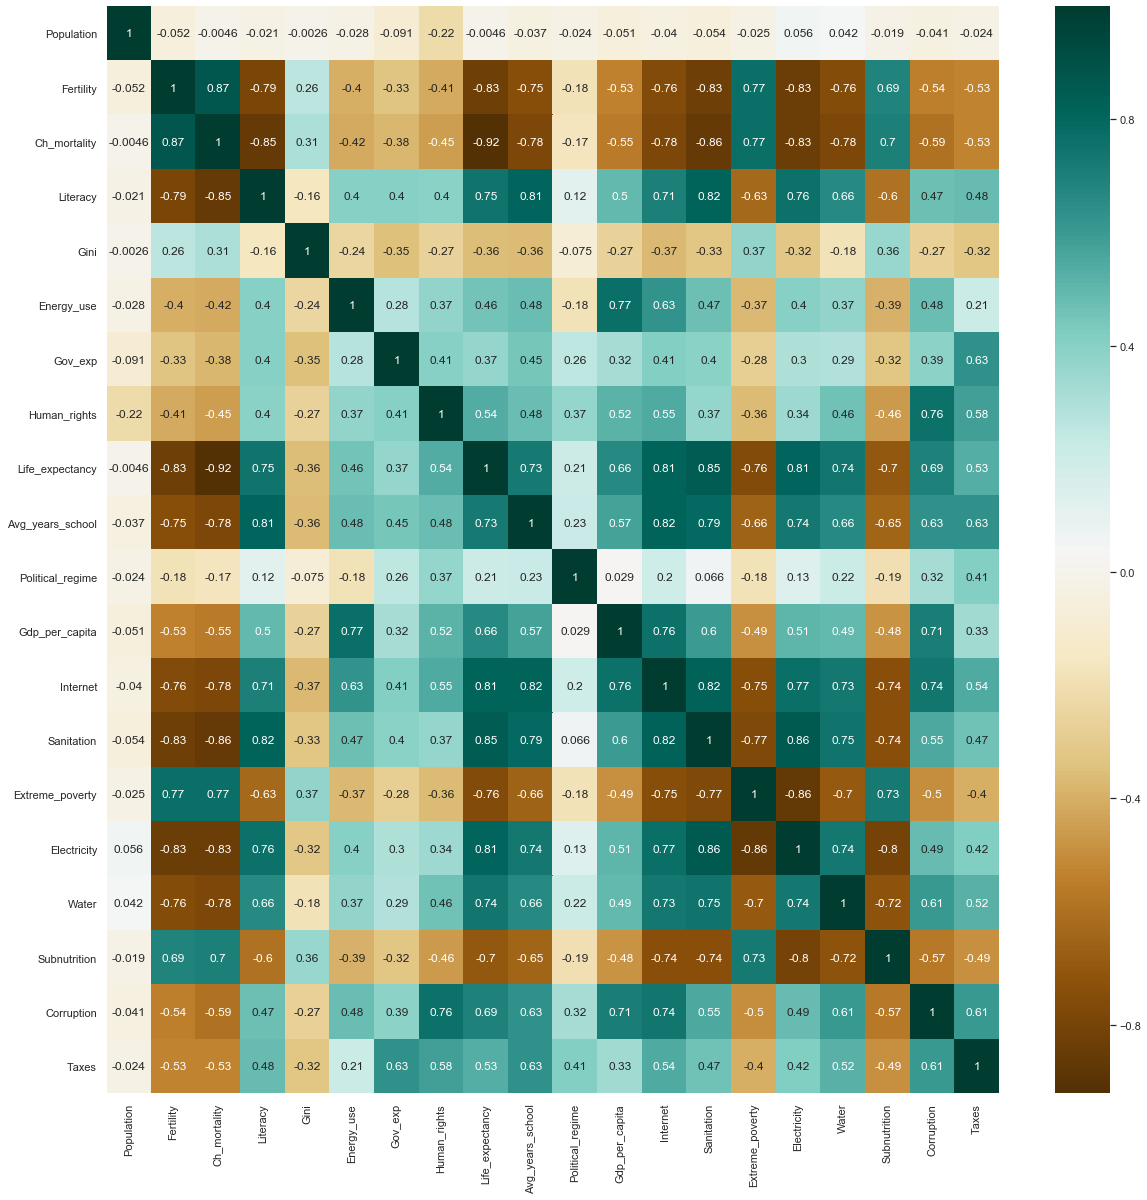

In [9]:
%matplotlib inline
sns.set(color_codes=True)
plt.figure(figsize=(20,20))
c= devfacts2.corr()
sns.heatmap(c,cmap='BrBG',annot=True)

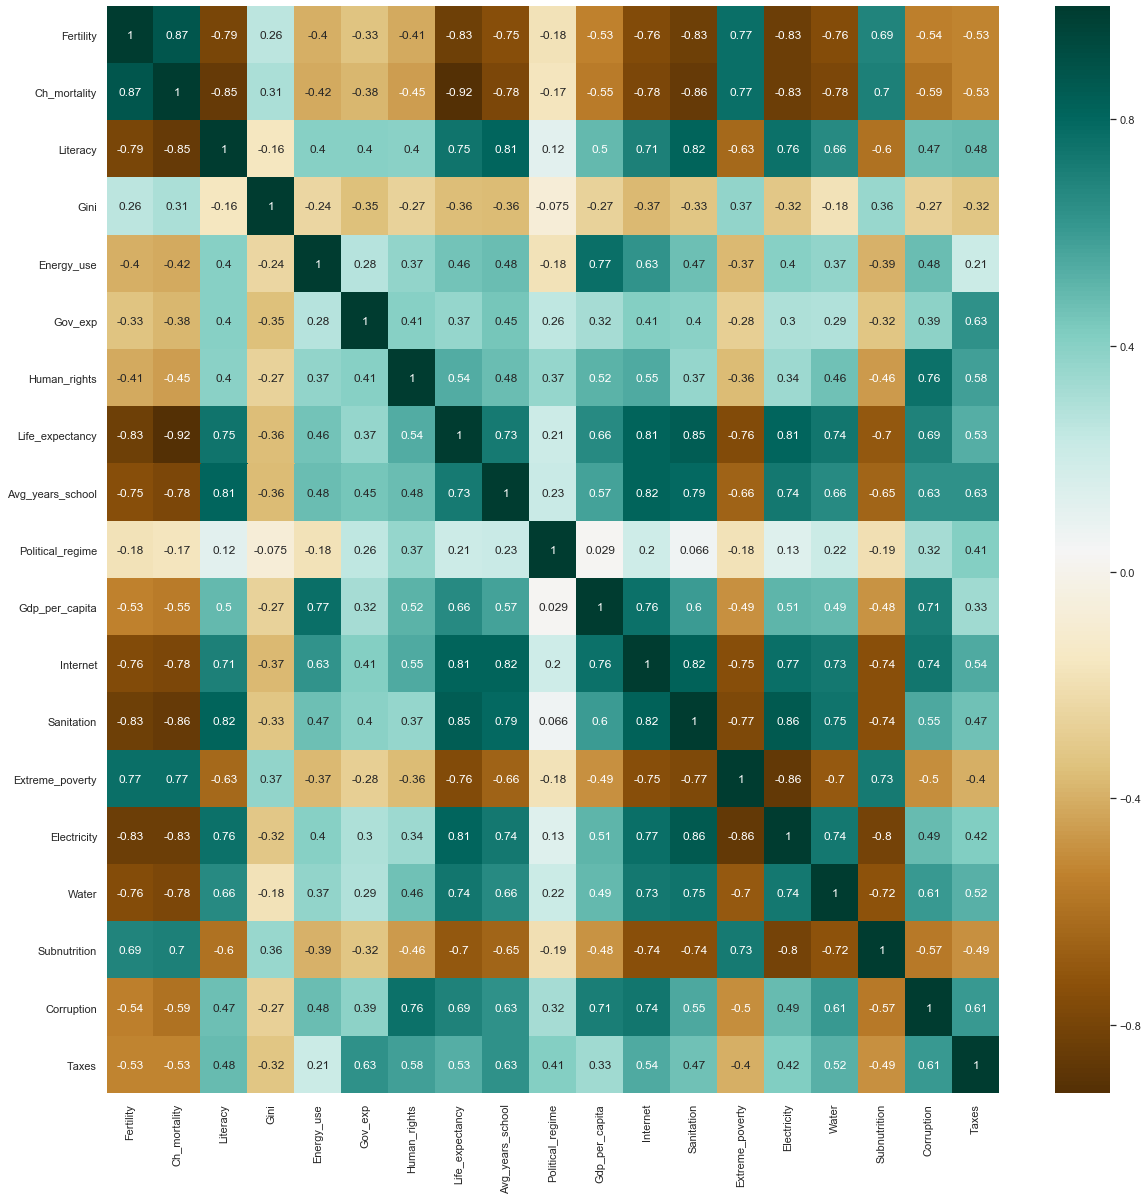

In [10]:
plt.figure(figsize=(20,20))
devfacts2_pop = devfacts2
devfacts2.drop('Population' , axis='columns', inplace=True)
c= devfacts2.corr()
sns.heatmap(c,cmap='BrBG',annot=True)

In [11]:
target = devfacts2.join(developed, how='left', sort=False).loc[:,['Developed']]
target.fillna(-1, inplace=True)
target = target.astype(dtype={'Developed' : int})

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

devext = ExtraTreesClassifier(n_estimators=10, max_depth=None,
min_samples_split=5, random_state=0)
scores_pop = cross_val_score(devext, devfacts2_pop, target.values.ravel(), cv=5)
scores = cross_val_score(devext, devfacts2, target.values.ravel(), cv=5)
scores_pop, scores 

(array([1.        , 0.97297297, 0.94594595, 0.94594595, 1.        ]),
 array([1.        , 0.97297297, 0.94594595, 0.94594595, 1.        ]))

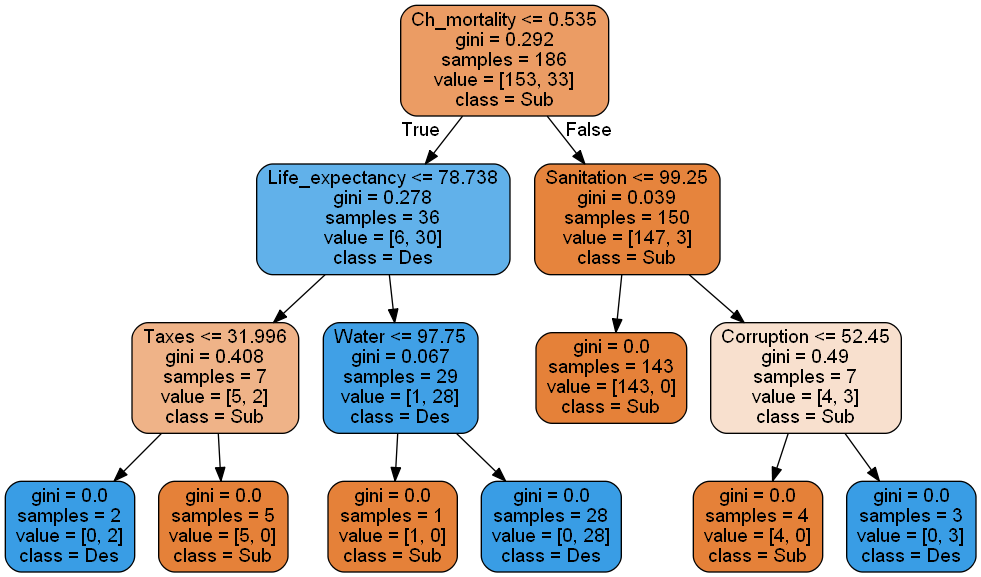

In [13]:
import pydotplus
from IPython.display import Image  
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# class labels
labels = devfacts2.columns

devtree = DecisionTreeClassifier( min_samples_split=5, random_state=0)
devtree.fit(devfacts2, target)

dot_data = export_graphviz(devtree, out_file=None,  feature_names=labels, class_names=['Sub','Des'], rounded=True, filled=True)

Image(pydotplus.graph_from_dot_data(dot_data).create_png())

In [14]:
dataset = devfacts2.join(developed, how='left', sort=False)
dataset.fillna(-1, inplace=True)
dataset = dataset.astype(dtype={'Developed' : int})

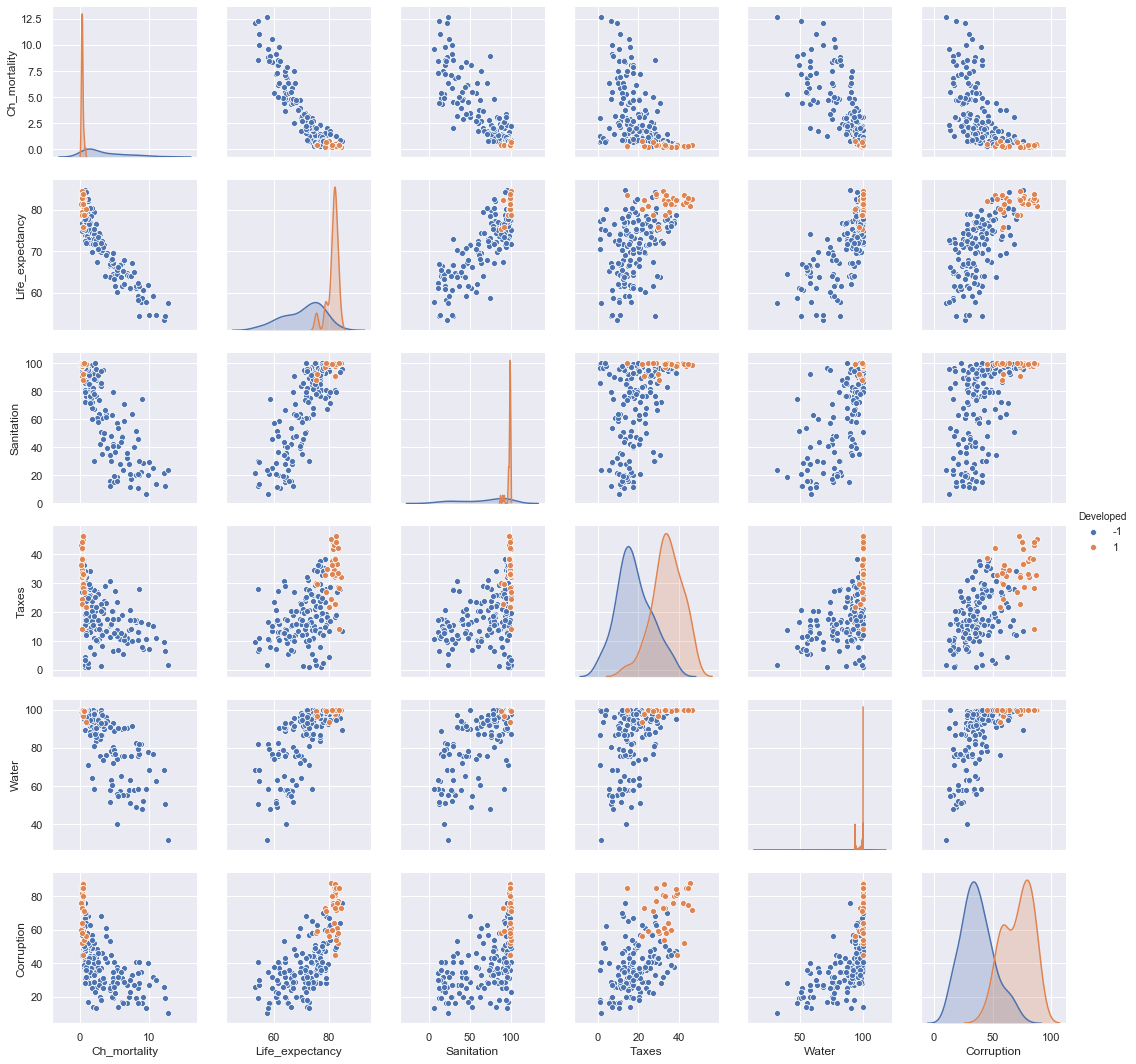

In [15]:
sns.pairplot(dataset, vars = ["Ch_mortality", "Life_expectancy", "Sanitation", "Taxes", "Water","Corruption"], hue = 'Developed')

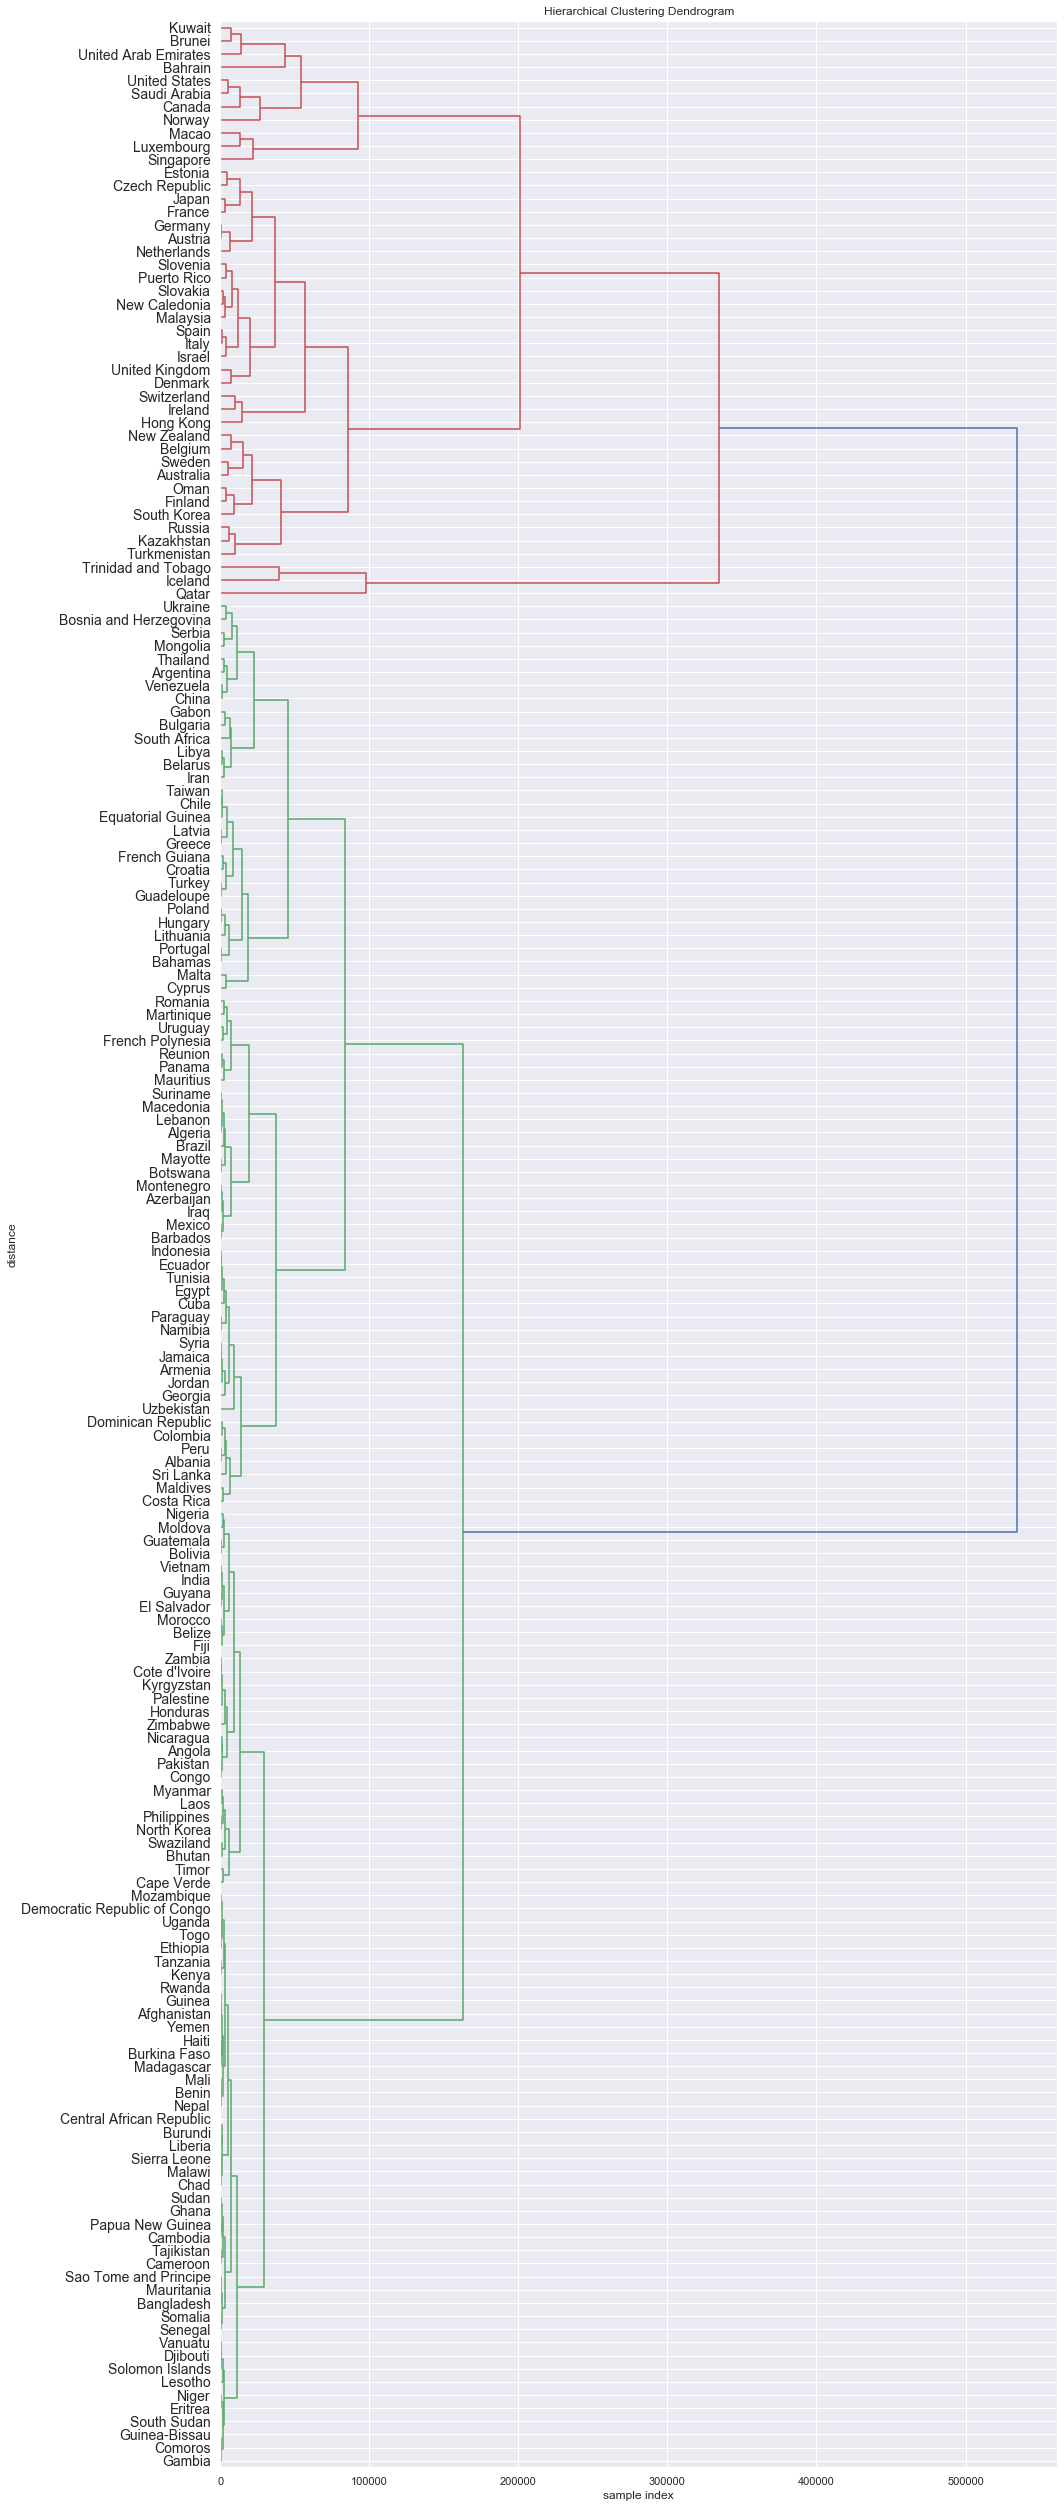

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

Z = linkage(devfacts2.to_numpy() , 'ward')
plt.figure(figsize=(15, 45))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
R = dendrogram(
    Z,
    leaf_font_size=14.,  # font size for the x axis labels
    orientation='right',
    labels=devfacts2.index.to_list())
plt.savefig('devfacts_dendrogram.png',bbox_inches='tight',pad_inches=0.5)
plt.show()



In [17]:
cl = R['color_list']
l = R['ivl']
id = leaves_list(Z)
cl[1], l[1], id[1], devfacts2.index[35]

('g', 'Comoros', 35, 'Comoros')

In [18]:
devclas=devtree.predict(devfacts2)
sub = []
dev = []
for i, v in enumerate(devclas.tolist()):
    if v==-1:
        sub.append(devfacts2.index[i])
    else:
        dev.append(devfacts2.index[i])
supsub = ', '.join(sub)
supdev = ', '.join(dev)
supsub, supdev

("Afghanistan, Albania, Algeria, Angola, Argentina, Armenia, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belize, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Brunei, Bulgaria, Burkina Faso, Burundi, Cambodia, Cameroon, Cape Verde, Central African Republic, Chad, Chile, China, Colombia, Comoros, Congo, Costa Rica, Cote d'Ivoire, Croatia, Cuba, Democratic Republic of Congo, Djibouti, Dominican Republic, Ecuador, Egypt, El Salvador, Equatorial Guinea, Eritrea, Ethiopia, Fiji, French Guiana, French Polynesia, Gabon, Gambia, Georgia, Ghana, Guadeloupe, Guatemala, Guinea, Guinea-Bissau, Guyana, Haiti, Honduras, Hong Kong, Hungary, India, Indonesia, Iran, Iraq, Jamaica, Jordan, Kazakhstan, Kenya, Kuwait, Kyrgyzstan, Laos, Lebanon, Lesotho, Liberia, Libya, Macao, Macedonia, Madagascar, Malawi, Malaysia, Maldives, Mali, Martinique, Mauritania, Mauritius, Mayotte, Mexico, Moldova, Mongolia, Montenegro, Morocco, Mozambique, Myanmar, Namibia, Nepal, New Caledo